In [1]:
# Code developer: Bahram Choubin (email: bahram368@gmail.com)
# Calulates the Catastrophe Model for each system/sub-system
# Run for each system/sub-system separately.
# Need raster layers with *.tif format and pos_neg.txt file like attached in Github
# All raster layers must have a float type. Make sure the NoData value is defined as -3.40282346639e+038.
# Raster names must be provided in alphabetic order (i.e., a.tif, b.tif,...), indicating their importance.
# pos_neg.txt file indicates relationship of each layer with target
# For more information see the reference provided in Github, also cite it


Minimum and Maximum Values for each raster:
Raster 'a.tif': Min = 0.0, Max = 1.0, Mean = 0.08973341518452421
Raster 'b.tif': Min = 0.0, Max = 1.0, Mean = 0.04502735312515733
Raster 'c.tif': Min = 0.0, Max = 1.0, Mean = 0.1591945976905839


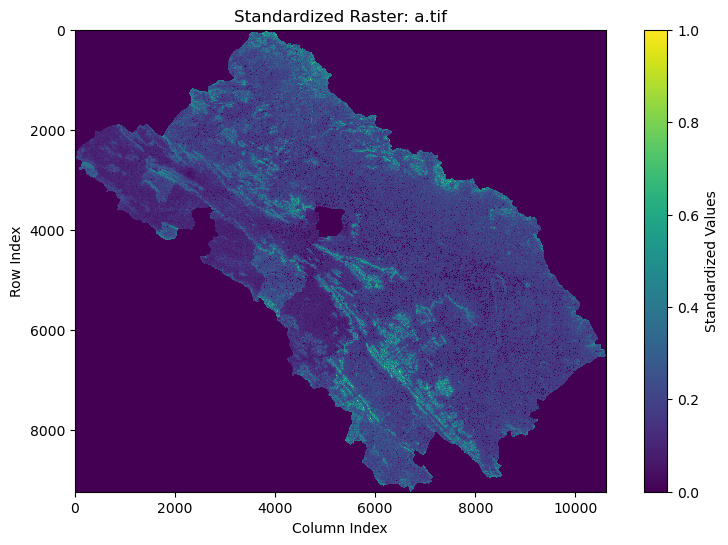

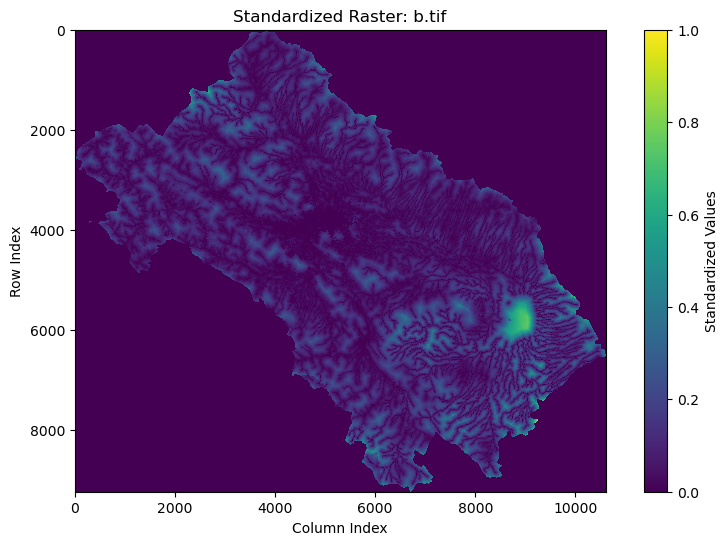

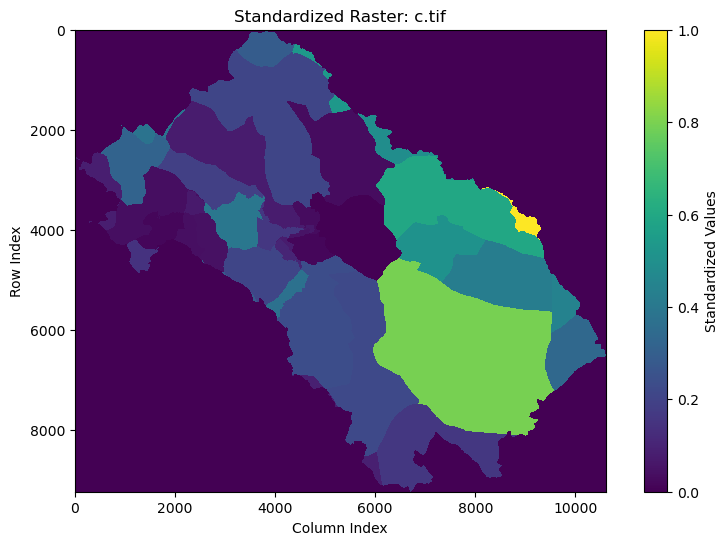

In [215]:
# 1- Standardization based on positive and negative scenarios  

# Example usage  
folder_path = 'E:/INSF_Resilience/GIS/Raster/Process'  
classification_file = 'E:/INSF_Resilience/GIS/Raster/Process/pos_neg.txt'  # Path to your pos-neg classifications file   

# Import necessary libraries  
import numpy as np  
import rasterio  
import os  
import matplotlib.pyplot as plt  # Import Matplotlib for plotting  

# Note: All raster layers must have float type and NoData Value must be defined as -3.40282346639e+038  

def standardize_raster(raster_file, is_positive=True):  
    with rasterio.open(raster_file) as src:  
        # Read the first band of the raster  
        data = src.read(1)  
    
        # Convert the fill value (-3.4028234663852886e+38) to NaN  
        data[data == -3.4028234663852886e+38] = np.nan  

        data_masked = np.ma.masked_invalid(data)  # Mask invalid data (NaNs)  

        # Get the minimum and maximum values for normalization  
        x_min = np.nanmin(data_masked)  
        x_max = np.nanmax(data_masked)  

        if x_max == x_min:  # If max equals min, handle division by zero  
            print(f"Warning: All data in '{os.path.basename(raster_file)}' is the same. Cannot standardize.")  
            return None  

        # Standardization  
        if is_positive:  # Positive scenario  
            standardized = (data_masked - x_min) / (x_max - x_min)  # Normalize to [0, 1]  
        else:  # Negative scenario  
            standardized = 1 - (data_masked - x_min) / (x_max - x_min)  # Inverted normalization  

        # Handle invalid data by setting standardized values to zero  
        standardized[data_masked.mask] = 0  

        return standardized  # Return the standardized raster data  

def process_rasters_in_folder(folder_path, classification_file):  
    standardized_results = {}  

    # Read classifications from the specified file  
    classifications_dict = {}  
    with open(classification_file, 'r') as f:  
        for line in f:  
            parts = line.strip().split()  
            if len(parts) == 2:  # Ensure there are exactly two elements  
                filename, classification = parts  
                classifications_dict[filename] = (classification.lower() == 'positive')  # Store as Boolean  

    # Get a list of all .tif files in the specified folder  
    raster_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.tif')]  

    for raster_path in raster_files:  
        file_name = os.path.basename(raster_path)  

        # Set is_positive based on classifications_dict  
        if file_name in classifications_dict:  
            is_positive = classifications_dict[file_name]  # Get value from dictionary  
        else:  
            print(f"Warning: '{file_name}' not found in classification file. Defaulting to positive.")  
            is_positive = True  # Defaulting might not be the best approach; consider raising an error  

        # Standardize the raster layer and get shape  
        standardized_data = standardize_raster(raster_path, is_positive)  
        standardized_results[raster_path] = standardized_data

    return standardized_results  # Return the standardized data   

# Function to plot standardized raster data  
def plot_standardized_rasters(standardized_results):  
    for raster_path, standardized in standardized_results.items():  
        if standardized is not None:  # Check if the data is valid  
            plt.figure(figsize=(10, 6))  
            plt.imshow(standardized, cmap='viridis', interpolation='nearest')  
            plt.colorbar(label='Standardized Values')  
            plt.title(f'Standardized Raster: {os.path.basename(raster_path)}')  
            plt.xlabel('Column Index')  
            plt.ylabel('Row Index')  
            plt.grid(False)  # Disable grid  
            plt.show()  # Display the plot  

# Process the raster files  
standardized_results = process_rasters_in_folder(folder_path, classification_file)  

# Print min and max values for each raster file  
print("\nMinimum and Maximum Values for each raster:")  
for raster_path, standardized in standardized_results.items():  
    if standardized is not None:  # Check if the standardized data is valid  
        # Calculate statistics  
        min_value = np.min(standardized)  # Calculate minimum value  
        max_value = np.max(standardized)  # Calculate maximum value   
        mean_value = np.mean(standardized)  # Calculate mean value  
        # Print results  
        print(f"Raster '{os.path.basename(raster_path)}': Min = {min_value}, Max = {max_value}, Mean = {mean_value}")  
    else:  
        print(f"Raster '{os.path.basename(raster_path)}': Standardization failed.")  

# Plot standardized raster maps  
plot_standardized_rasters(standardized_results)  

Swallowtail Normalized Values:
  xa = (9229, 10602)
    Min: 0.0, Max: 1.0, Mean: 0.1938873827457428
  xb = (9229, 10602)
    Min: 0.0, Max: 1.0, Mean: 0.18612581491470337
  xc = (9229, 10602)
    Min: 0.0, Max: 1.0, Mean: 0.31996938586235046


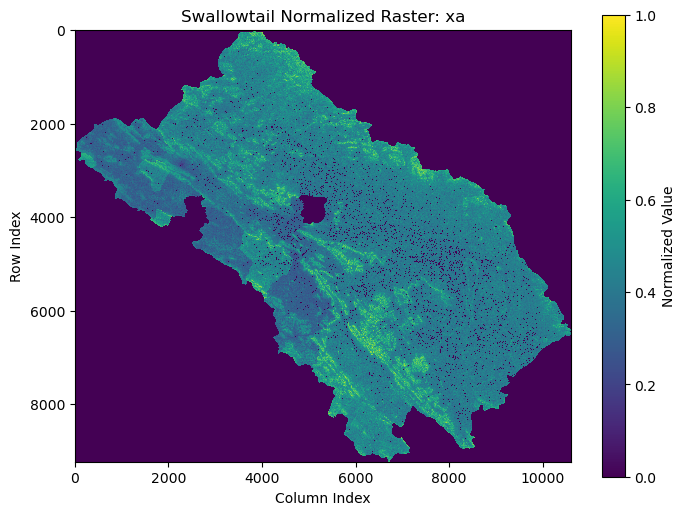

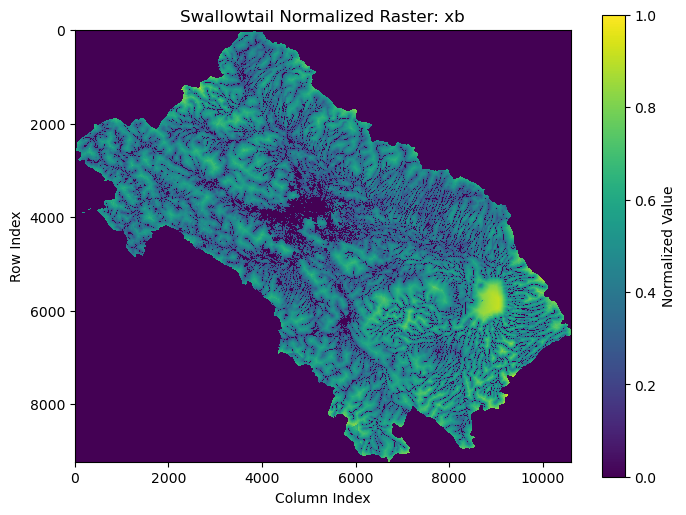

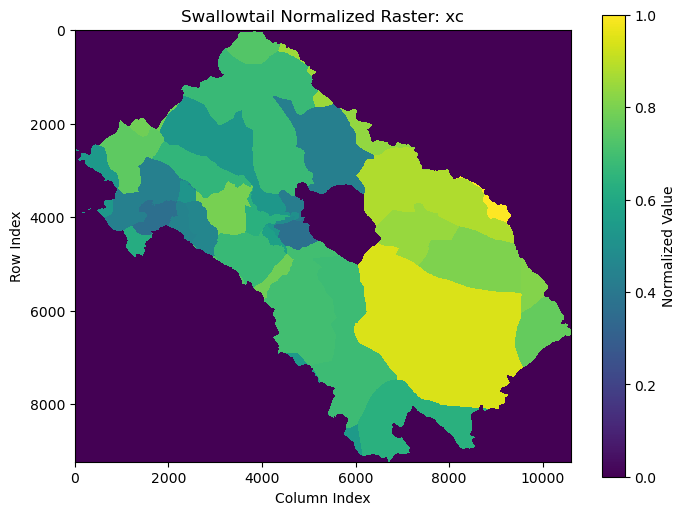

In [216]:
# 2- Calculating Normalized Rasters According to Catastrophic Models

import numpy as np  

def normalize_rasters(standardized_results):  
    # Determine the number of standardized results  
    num_rasters = len(standardized_results)  

    # Create an empty dictionary to hold normalized results  
    normalized_results = {}  

    if num_rasters == 0:  
        print("Warning: No standardized results available for normalization.")  
        return normalized_results  

    # Prepare to extract the standardized values  
    standardized_values = list(standardized_results.values())  

    if num_rasters == 1:  # Fold Model  
        a = standardized_values[0]  
        normalized_xa = a ** (1/2)   
        normalized_results['Fold'] = normalized_xa  

    elif num_rasters == 2:  # Cusp Model  
        a = standardized_values[0]  
        b = standardized_values[1]  
        normalized_xa = a ** (1/2)  
        normalized_xb = b ** (1/3)    
        normalized_results['Cusp'] = (normalized_xa, normalized_xb)  

    elif num_rasters == 3:  # Swallowtail Model  
        a = standardized_values[0]  
        b = standardized_values[1]  
        c = standardized_values[2]  
        normalized_xa = a ** (1/2)    
        normalized_xb = b ** (1/3)   
        normalized_xc = c ** (1/4)  
        normalized_results['Swallowtail'] = (normalized_xa, normalized_xb, normalized_xc)  

    elif num_rasters == 4:  # Butterfly Model  
        a = standardized_values[0]  
        b = standardized_values[1]  
        c = standardized_values[2]  
        d = standardized_values[3]  
        normalized_xa = a ** (1/2)    
        normalized_xb = b ** (1/3)  
        normalized_xc = c ** (1/4)  
        normalized_xd = d ** (1/5)    
        normalized_results['Butterfly'] = (normalized_xa, normalized_xb, normalized_xc, normalized_xd)  

    else:  
        print(f"Warning: Unsupported number of rasters ({num_rasters}). Only supports up to 4 rasters.")  

    return normalized_results  

# Function to plot normalized rasters  
def plot_normalized_rasters(normalized_results):  
    for model, values in normalized_results.items():  
        if isinstance(values, tuple):  
            for idx, value in enumerate(values):  
                plt.figure(figsize=(8, 6))  
                plt.imshow(value, cmap='viridis', interpolation='nearest')  
                plt.colorbar(label='Normalized Value')  
                plt.title(f'{model} Normalized Raster: x{chr(97 + idx)}')  
                plt.xlabel('Column Index')  
                plt.ylabel('Row Index')  
                plt.grid(False)  
                plt.show()  
        else:  
            plt.figure(figsize=(8, 6))  
            plt.imshow(values, cmap='viridis', interpolation='nearest')  
            plt.colorbar(label='Normalized Value')  
            plt.title(f'{model} Normalized Raster: xa')  
            plt.xlabel('Column Index')  
            plt.ylabel('Row Index')  
            plt.grid(False)  
            plt.show()  

# Normalize the results (ensure standardized_results are defined before this)  
normalized_results = normalize_rasters(standardized_results)  

# Print out the normalized results for verification  
for model, values in normalized_results.items():  
    print(f"{model} Normalized Values:")  
    if isinstance(values, tuple):  
        for idx, value in enumerate(values):  
            print(f"  x{chr(97 + idx)} = {value.shape}")  # Print shape of the 2D array for better readability  
            # Print min, max, and mean values for each normalized array  
            print(f"    Min: {np.min(value)}, Max: {np.max(value)}, Mean: {np.mean(value)}")  
    else:  
        print(f"  xa = {values.shape}")  # Print shape of the single value's array  
        print(f"    Min: {np.min(values)}, Max: {np.max(values)}, Mean: {np.mean(values)}")  
        
# Now plot the normalized rasters  
plot_normalized_rasters(normalized_results)


Correlation Matrix among Normalized Rasters:
                  Swallowtail_var1  Swallowtail_var2  Swallowtail_var3
Swallowtail_var1          1.000000          0.840428          0.865658
Swallowtail_var2          0.840428          1.000000          0.830156
Swallowtail_var3          0.865658          0.830156          1.000000
Non-complementarity approach selected.
Minimum value calculated across all rasters for non-complementarity.

Computed Pixel-based Variable x shape: (97845858,)

Correlation Matrix among Normalized Rasters:
                  Swallowtail_var1  Swallowtail_var2  Swallowtail_var3
Swallowtail_var1          1.000000          0.840428          0.865658
Swallowtail_var2          0.840428          1.000000          0.830156
Swallowtail_var3          0.865658          0.830156          1.000000
Non-complementarity approach selected.
Minimum value calculated across all rasters for non-complementarity.

Computed Pixel-based Variable x shape: (97845858,)


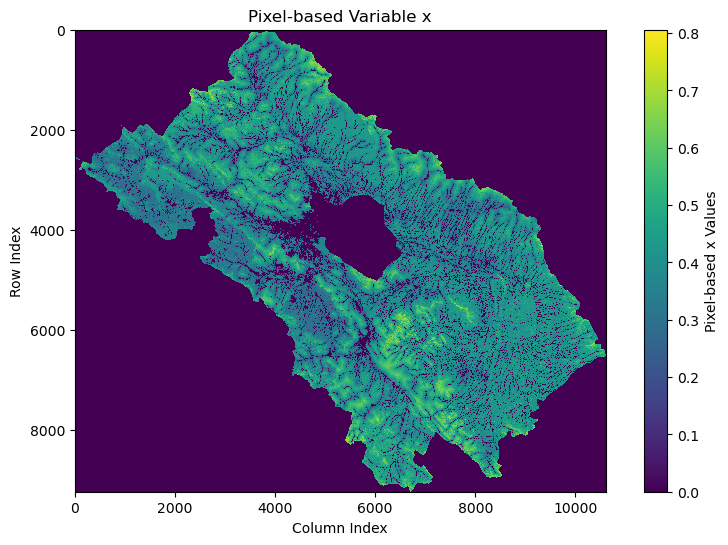

In [217]:
# 3- Complementarity and calculate x  

# If you normalized your variables between 0 and 1, where 1 represents high resilience (Positive/Negative scenarios),  
# you can draw the relationships of variables based on correlation:  
# negative correlation = complementarity  
# positive correlation = non-complementarity  

import pandas as pd   
import numpy as np  
import matplotlib.pyplot as plt  
from numpy.ma import masked_array  

def calculate_correlation(normalized_results):  
    """Calculate the correlation matrix from normalized raster results."""  
    data_arrays = {}  
    
    for variable_name, data_tuple in normalized_results.items():  
        for idx, normalized in enumerate(data_tuple):  
            if normalized is not None:  
                data_arrays[f"{variable_name}_var{idx + 1}"] = normalized.compressed()   

    # Convert the dictionary to a DataFrame only if data_arrays is not empty  
    if data_arrays:  
        data_df = pd.DataFrame(data_arrays)  
        correlation_matrix = data_df.corr()  
    else:  
        print("No valid normalized data provided.")  
        return pd.DataFrame()  
    
    return correlation_matrix  

def calculate_pixel_based_x(correlation_matrix, normalized_results):  
    """Calculate pixel-based variable x based on correlation results."""  
    corr_threshold = (correlation_matrix < 0.5).any().any()  

    if corr_threshold:  
        print("Complementarity approach selected.")  
        stacked_data = np.stack([data.compressed() for data_tuple in normalized_results.values() for data in data_tuple])  
        x = np.mean(stacked_data, axis=0)  
        print("Mean value calculated across all rasters for complementarity.")  
    else:  
        print("Non-complementarity approach selected.")  
        stacked_data = np.stack([data.compressed() for data_tuple in normalized_results.values() for data in data_tuple])  
        x = np.min(stacked_data, axis=0)  
        print("Minimum value calculated across all rasters for non-complementarity.")  
    
    return x  


# Calculate and display the correlation matrix  
correlation_matrix = calculate_correlation(normalized_results)  
print("\nCorrelation Matrix among Normalized Rasters:")  
print(correlation_matrix)  

# Calculate pixel-based variable x based on the correlation results  
variable_x = calculate_pixel_based_x(correlation_matrix, normalized_results)  

# Print shape to help with dimensions  
print(f"\nComputed Pixel-based Variable x shape: {variable_x.shape}")  

primary_raster_file = "a.tif"
with rasterio.open(os.path.join(folder_path, primary_raster_file)) as src:  
    primary_band = src.read(1) 
raster_shape = primary_band.shape


def plot_variable_x(variable_x, title='Pixel-based Variable x'):  
    """Plot the pixel-based variable x as a raster image."""  
    # Reshape variable_x to (9229, 10602) for plotting  
    variable_x_reshaped = variable_x.reshape(raster_shape)  

    plt.figure(figsize=(10, 6))  
    plt.imshow(variable_x_reshaped, cmap='viridis', interpolation='nearest')  # Plot the reshaped variable  
    plt.colorbar(label='Pixel-based x Values')  
    plt.title(title)  
    plt.xlabel('Column Index')  
    plt.ylabel('Row Index')  
    plt.grid(False)  
    plt.show()  

# Calculate and display the correlation matrix  
correlation_matrix = calculate_correlation(normalized_results)  
print("\nCorrelation Matrix among Normalized Rasters:")  
print(correlation_matrix)  

# Calculate pixel-based variable x based on the correlation results  
variable_x = calculate_pixel_based_x(correlation_matrix, normalized_results)  

# Print shape to help with dimensions  
print(f"\nComputed Pixel-based Variable x shape: {variable_x.shape}")  

# Plot the pixel-based variable x  
plot_variable_x(variable_x, title='Pixel-based Variable x')  

{'Swallowtail': masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)}
Swallowtail PF Values:
  xa = (9229, 10602)
    Min: 0.0, Max: 0.9059482216835022, Mean: 0.06536305808673067


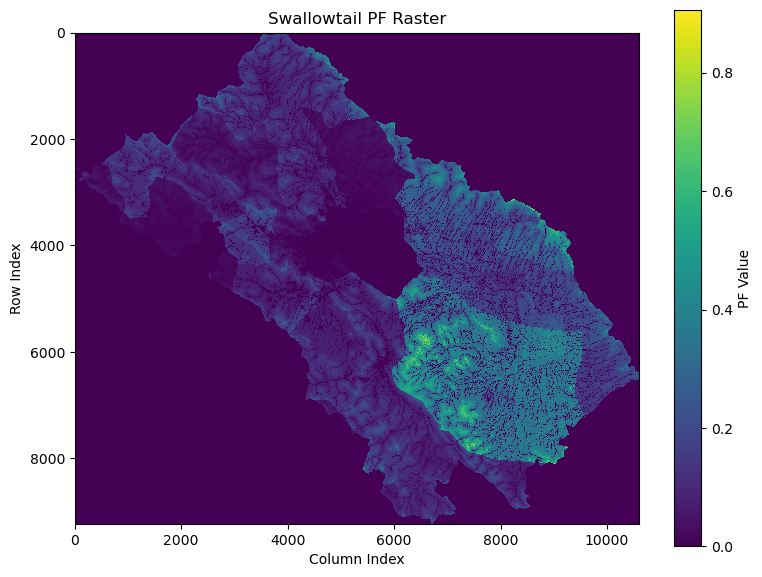

In [218]:
# 4- Calculating the Potential Function of Catastrophic Models

import numpy as np  
import matplotlib.pyplot as plt  # Importing matplotlib for plotting  

# Example: Define variable_x and raster_shape according to your data  
# variable_x = np.array([...])   # Shape to be compatible with raster_shape  
# raster_shape = (size,) # Define size appropriately  

x = variable_x.reshape(raster_shape)  

def PF_raster(standardized_results):  
    # Determine the number of standardized results  
    num_rasters = len(standardized_results)  

    # Create an empty dictionary to hold PF results  
    PF_results = {}  

    if num_rasters == 0:  
        print("Warning: No standardized results available for calculation.")  
        return PF_results  

    # Prepare to extract the standardized values  
    standardized_values = list(standardized_results.values())  

    if num_rasters == 1:  # Fold Model  
        a = standardized_values[0]  
        PF = (1/3) * x**3 + a * x  
        PF_results['Fold'] = PF  

    elif num_rasters == 2:  # Cusp Model  
        a = standardized_values[0]  
        b = standardized_values[1]  
        PF = (1/4) * x**4 + (1/2) * a * x**2 + b * x  
        PF_results['Cusp'] = PF  

    elif num_rasters == 3:  # Swallowtail (Dovetail) Model  
        a = standardized_values[0]  
        b = standardized_values[1]  
        c = standardized_values[2]  
        PF = (1/5) * x**5 + (1/3) * a * x**3 + (1/2) * b * x**2 + c * x  
        PF_results['Swallowtail'] = PF  

    elif num_rasters == 4:  # Butterfly Model  
        a = standardized_values[0]  
        b = standardized_values[1]  
        c = standardized_values[2]  
        d = standardized_values[3]  
        PF = (1/6) * x**6 + (1/4) * a * x**4 + (1/3) * b * x**3 + (1/2) * c * x**2 + d * x  
        PF_results['Butterfly'] = PF  

    else:  
        print(f"Warning: Unsupported number of rasters ({num_rasters}). Only supports up to 4 rasters.")  

    return PF_results  

# Normalize the results (ensure standardized_results is defined before this)  
PF_results = PF_raster(standardized_results)   
print(PF_results)  

# Function to plot normalized rasters  
def plot_PF_raster(PF_results):  
    for model, values in PF_results.items():  
        plt.figure(figsize=(8, 6))  
        if isinstance(values, tuple):  
            for idx, value in enumerate(values):  
                plt.subplot(1, len(values), idx + 1)  # Create subplots for each raster  
                plt.imshow(value, cmap='viridis', interpolation='nearest')  
                plt.colorbar(label='PF Value')  
                plt.title(f'{model} PF Raster: x{chr(97 + idx)}')  
                plt.xlabel('Column Index')  
                plt.ylabel('Row Index')  
                plt.grid(False)  
        else:  
            plt.imshow(values, cmap='viridis', interpolation='nearest')  
            plt.colorbar(label='PF Value')  
            plt.title(f'{model} PF Raster')  
            plt.xlabel('Column Index')  
            plt.ylabel('Row Index')  
            plt.grid(False)  
        
        plt.tight_layout()  # Adjust subplots to fit in the figure area  
        plt.show()  
            
# Print out the PF results for verification  
for model, values in PF_results.items():  
    print(f"{model} PF Values:")  
    if isinstance(values, tuple):  
        for idx, value in enumerate(values):  
            print(f"  x{chr(97 + idx)} = {value.shape}")  # Print shape of the 2D array for better readability  
            # Print min, max, and mean values for each normalized array  
            print(f"    Min: {np.min(value)}, Max: {np.max(value)}, Mean: {np.mean(value)}")  
    else:  
        print(f"  xa = {values.shape}")  # Print shape of the single value's array  
        print(f"    Min: {np.min(values)}, Max: {np.max(values)}, Mean: {np.mean(values)}")  
        
# Now plot the normalized rasters  
plot_PF_raster(PF_results)

In [219]:
# 5- Write

import os  
import numpy as np  
import rasterio  
from rasterio.transform import from_origin  # For setting georeference parameters  

# Function to save PF results as GeoTIFF with characteristics of an input raster  
def save_to_geotiff(PF_results, input_raster_file, directory='folder_path', filename_prefix="PF_"):  
    """  
    Save the PF_results dictionary as GeoTIFF files with characteristics inherited from an input raster.  

    Parameters:  
        PF_results (dict): Dictionary containing the potential function results.  
        input_raster_file (str): Path to the input raster file for characteristics.  
        directory (str): Directory where the files will be saved. Default is the current directory.  
        filename_prefix (str): Prefix for the filenames. Default is "PF_".  
    """  
    # Read characteristics from the input raster  
    with rasterio.open(input_raster_file) as src:  
        crs = src.crs  # Coordinate Reference System  
        transform = src.transform  # Transform for extent and pixel size  
        # Assuming square pixels  
        pixel_size = transform[0]  # x pixel size  
        # If you need extent values, you can get them like the following:  
        # min_x, min_y, max_x, max_y = src.bounds  # This gives bounds of the raster  

    for model, values in PF_results.items():  
        # Construct the filename  
        filename = os.path.join(directory, f"{filename_prefix}{model}.tif")  
        
        # Set metadata for the raster file  
        meta = {  
            'driver': 'GTiff',  
            'count': 1,  
            'dtype': 'float32',  # Adjust based on the data type  
            'width': values.shape[1],  
            'height': values.shape[0],  
            'crs': crs,  # Coordinate Reference System from input raster  
            'transform': transform  # Transform from input raster for extent and pixel size  
        }  
        
        # Write the data to a GeoTIFF  
        with rasterio.open(filename, 'w', **meta) as dst:  
            dst.write(values, 1)  # Write the array to the first band  
            print(f"Successfully saved {model} to {filename}")  # Confirm save  


input_raster_path = os.path.join(folder_path, primary_raster_file)  

 
save_to_geotiff(PF_results, input_raster_path, directory=folder_path)  

Successfully saved Swallowtail to E:/INSF_Resilience/GIS/Raster/Process\PF_Swallowtail.tif
